In [1]:
# Import necessary libraries
from shapely.geometry import Point, Polygon, box
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import color
import geopandas as gpd
from PIL import Image
import pandas as pd
import numpy as np
import cv2 as cv
import requests
import shapely
import pickle
import glob
import time
import sys
import os

import sys
def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.3+
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print("{}[{}{}] {}/{}".format(prefix, "#"*x, "."*(size-x), j, count), 
                end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

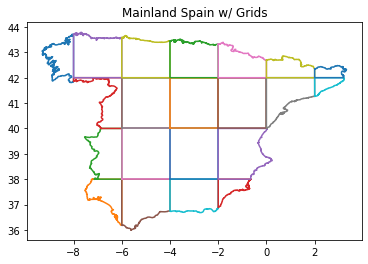

In [2]:
# Load and dispay gridded geometry of Spain
espPolyGrid = pickle.load(open("data/espPolyGrid.pkl",'rb'))
for i in espPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
plt.title("Mainland Spain w/ Grids")
plt.show()

<AxesSubplot:>

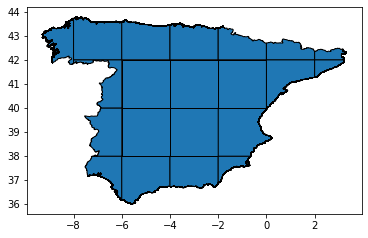

In [3]:
# Convert to GeoDataFrame object
polyList = []
for x in espPolyGrid.keys():
    polyList.append(Polygon(np.flip(espPolyGrid[x])))
grid = gpd.GeoDataFrame(geometry=polyList)
grid.plot(edgecolor='black')

In [7]:
# Get dictionary data set referencing all images
db = pd.read_csv("dict/overall.csv")

In [8]:
db.shape

(13099, 7)

In [9]:
db.head()

,grid,lat,lng,pano,file,ssd,official
0,3,41.191465,-6.501397,UZZJ1CAZVg97GK1FZ4m-3w,grid3_img1.jpg,2.412823,1
1,3,41.078698,-6.109293,4JZsMwNGj2n0jOdnyA8ehQ,grid3_img2.jpg,1.714572,1
2,3,41.409721,-6.144616,J2Rv7H5237m-LQLlobh9WA,grid3_img3.jpg,1.330829,1
3,3,40.651804,-6.456966,xBWuycQE4YEDh1ManwW8yw,grid3_img4.jpg,0.963378,1
4,3,40.257330,-6.402230,uNvN367WDW5sHoENy6cytw,grid3_img5.jpg,0.961591,1


Text(30.25, 0.5, 'Latitude')

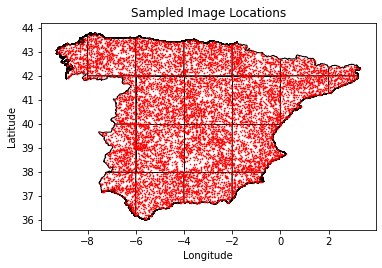

In [10]:
# Plot all images
grid.plot(edgecolor='black',color='white')
plt.scatter(db.lng,db.lat,c='red',s=0.25)
plt.title("Sampled Image Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.savefig("sampledImages.png",dpi=400)

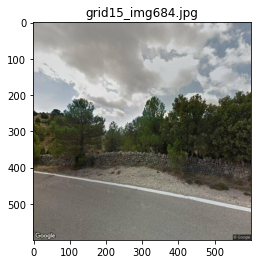

In [70]:
# Display random image
sample = db.sample(1)
randomImg = mpimg.imread("images/raw/{}".format(sample.file.item()))
plt.imshow(randomImg)
plt.title(sample.file.item())
plt.show()

sample.head()

# Save random image for testing
pilImg = Image.fromarray(randomImg)
pilImg.save("testImages/randomImg.jpg")

In [31]:
template = color.rgb2gray(Image.open("testImages/copyrightTemplate.jpg"))
npTemp = np.array(template)
npTemp[npTemp < 0.25] = 0

db['ssd'] = None
res_list = []

for i in progressbar(db.index,"Computing: ",20):
    fileName = db.file[i]
    imgIt = Image.fromarray(color.rgb2gray(Image.open("images/raw/{}".format(fileName))))
    
    imgCrop = imgIt.crop((550,585,600,600))
    imgCrop = np.array(imgCrop)
    imgCrop[imgCrop < 0.25] = 0
    imgCrop = np.where(npTemp > 0, imgCrop, 0)
    
    db.at[i,"ssd"] = np.sum((npTemp-imgCrop)**2)

db['official'] = np.where(db.ssd<5,1,0)
db.to_csv("dict/overall.csv",index=False,encoding='utf-8')

Computing: [####################] 13099/13099



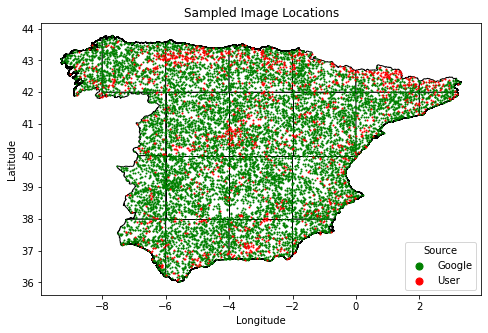

In [23]:
# Plot all images
fig,ax = plt.subplots(figsize=(15,5))
grid.plot(ax=ax,edgecolor='black',color='white')
ax.scatter(db[db.official == 1].lng,db[db.official == 1].lat,c='green',s=1,label='Google')
ax.scatter(db[db.official == 0].lng,db[db.official == 0].lat,c='red',s=1,label='User')
lgnd = plt.legend(title='Source',loc='lower right')
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
ax.set_title("Sampled Image Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig("sourceImages.png",dpi=400)

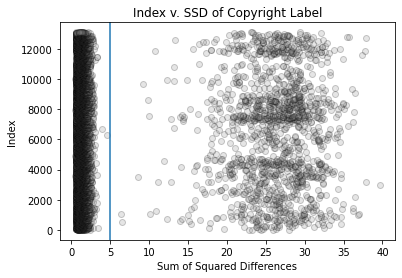

In [33]:
plt.scatter(db.ssd,db.index,edgecolor='black',alpha=0.2,color='grey')
plt.axvline(5)
plt.xlabel("Sum of Squared Differences")
plt.ylabel("Index")
plt.title("Index v. SSD of Copyright Label")
plt.savefig("ssdCopyright.png",dpi=400)

In [71]:
# Manual accuracy check
for i in list(db[db.ssd > 5].sort_values(by='ssd',ascending=True).index)[0:50]:
    fileName = db.file[i]
    imgIt = Image.fromarray(color.rgb2gray(Image.open("images/{}/{}".format(fileName.split("_")[0],fileName))))

    imgCrop = imgIt.crop((550,585,600,600))
    imgCrop = np.array(imgCrop)

    plt.imshow(imgCrop)
    plt.show()

1

In [88]:
db.official.value_counts()

1    11654
0     1445
Name: official, dtype: int64

In [89]:
db.official.mean()

0.8896862355905031